In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as T
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight
import seaborn as sns
sns.set(font_scale=1.2)

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'
    
modelname = "densenet121"

Available workers: 16


# Creating train,val,test sets

## Removing outliers

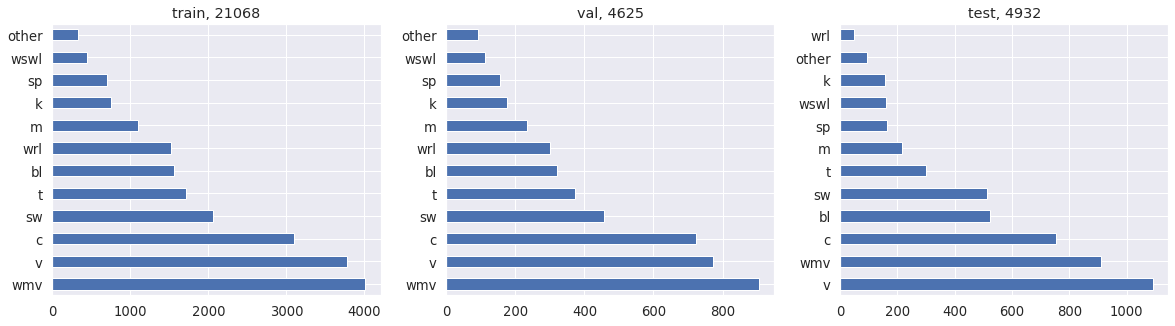

In [3]:
df_train = pd.read_parquet(f"{SAVE_DIR}/df_train_{setting}.parquet")
df_val = pd.read_parquet(f"{SAVE_DIR}/df_val_{setting}.parquet")
df_test = pd.read_parquet(f"{SAVE_DIR}/df_test_{setting}.parquet")

topclasses = df_train['txt_label'].unique().tolist()

plt.figure(figsize=(20,5))
plt.subplot(1,3,1);df_train.txt_label.value_counts().plot(kind='barh');plt.title(f'train, {df_train.shape[0]}')
plt.subplot(1,3,2);df_val.txt_label.value_counts().plot(kind='barh');plt.title(f'val, {df_val.shape[0]}')
plt.subplot(1,3,3);df_test.txt_label.value_counts().plot(kind='barh');plt.title(f'test, {df_test.shape[0]}');

plt.savefig(f"/home/kalfasyan/Dropbox/worklaptop_results/datacounts_{modelname}_{setting}.png", format='png', bbox_inches='tight')

In [4]:
assert len(set(df_train.filename.tolist()).intersection(df_test.filename.tolist())) == 0
assert len(set(df_train.filename.tolist()).intersection(df_val.filename.tolist())) == 0

In [5]:
df_train.label.value_counts()

9     4006
8     3779
7     3098
4     2055
3     1717
0     1563
10    1523
6     1100
5      752
2      706
1      438
11     331
Name: label, dtype: int64

# Creating Pytorch Datasets and Dataloaders

In [6]:
transforms_list_train = [
#     A.SmallestMaxSize(max_size=150),
    T.ToPILImage(),
    T.Resize(size=(150,150)),
    T.RandomVerticalFlip(p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAutocontrast(p=0.5),
    T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5),
    T.RandomRotation(degrees=(-5,5)),
    T.RandomPosterize(bits=7, p=0.1),
    # T.RandomEqualize(p=0.5),
    T.ToTensor(),
]

transforms_list_test = [
    T.ToPILImage(),
    T.Resize(size=(150,150)),    
    T.ToTensor(),
]

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=T.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=T.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=T.Compose(transforms_list_test))

batch_size = 32
batch_size_val = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

# plt.imshow(train_dataset[0][0]); plt.title(f"Example train image, class:{train_dataset[0][1]}");

# Defining the model and training parameters

In [7]:
torch.backends.cudnn.benchmark = True

In [8]:
model = model_selector(modelname, pretrained=True)

if modelname.startswith("dense"):
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
                            nn.Linear(num_ftrs,512),
                            nn.ReLU(),
                            nn.Dropout(0.5),
                            nn.Linear(512, len(topclasses)))
if modelname.startswith("resn"):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("efficient"):
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("vgg"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))
if modelname.startswith("mobile"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))
    
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

num_epochs = 40

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda(), label_smoothing=.15)

Train on gpu: True


In [9]:
optimizer = optim.Adam(model.parameters(), lr=.001)

model, optimizer = load_checkpoint(f'{SAVE_DIR}/{modelname}_{setting}_best.pth.tar', model, optimizer)
model = model.to('cuda', dtype=torch.float)

In [10]:
class_mapping = {'bl':'0','wswl':'1','sp':'2','t':'3','sw':'4','k':'5','m':'6','c':'7','v':'8','wmv':'9','wrl':'10', 'other':11}

labelticks = list(class_mapping.keys())

Testing..	: 100%|████████████████████████████████████████████████████████████████████████████████| 659/659 [00:28<00:00, 22.91it/s]


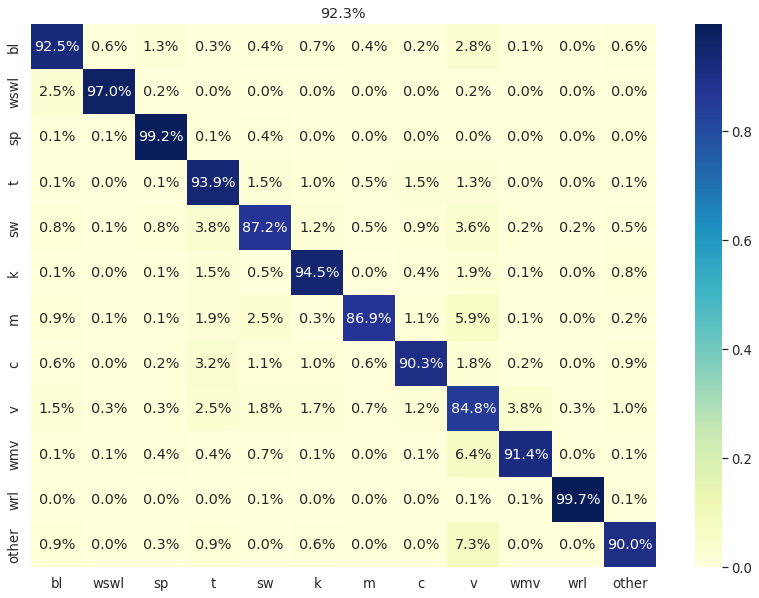

In [11]:
train_bacc, train_cm, y_true, y_pred, info = test_model(model,train_dataloader, train_dataset)
plt.figure(figsize=(14,10))
sns.heatmap(train_cm, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=labelticks, yticklabels=labelticks); plt.title(f"{train_bacc*100:.1f}%");

Testing..	: 100%|████████████████████████████████████████████████████████████████████████████████| 145/145 [00:06<00:00, 23.23it/s]


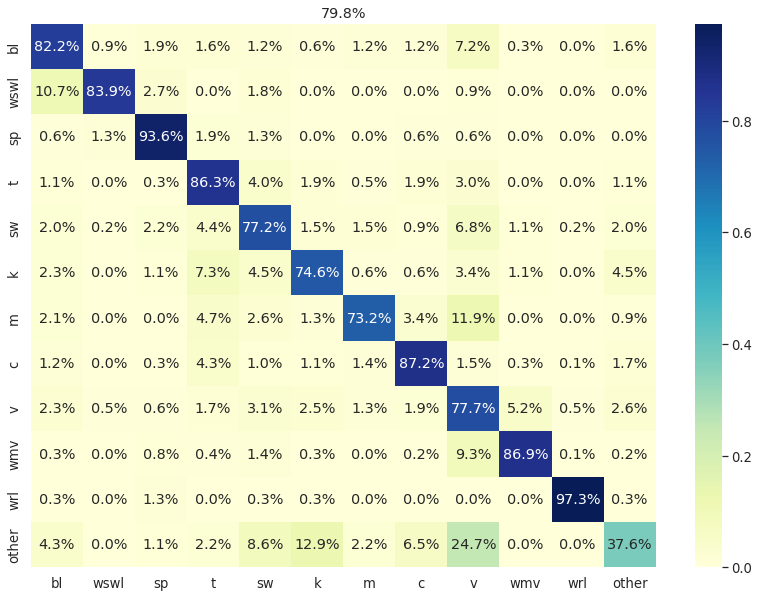

In [12]:
val_bacc, val_cm, _, _, _ = test_model(model,valid_dataloader, valid_dataset)
plt.figure(figsize=(14,10))
sns.heatmap(val_cm, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=labelticks, yticklabels=labelticks); plt.title(f"{val_bacc*100:.1f}%");

Testing..	: 100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [01:06<00:00,  2.32it/s]


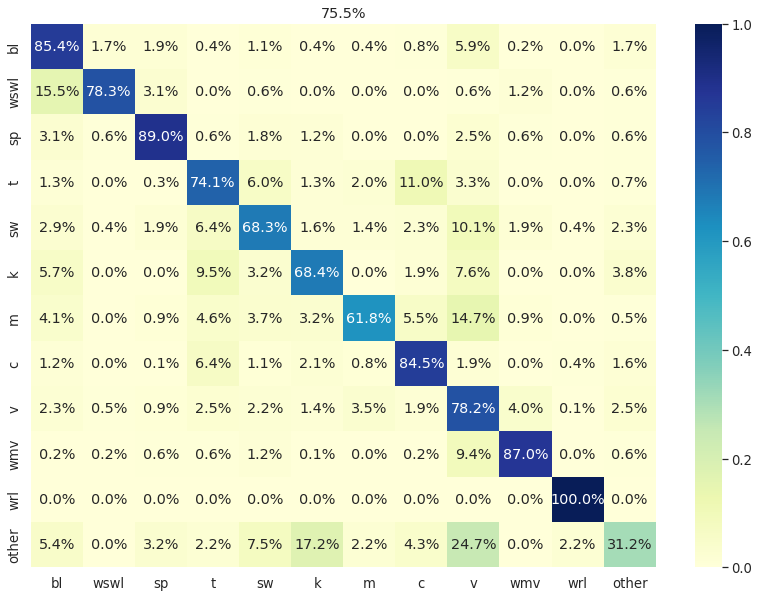

In [13]:
test_bacc, test_cm, y_true, y_pred, info = test_model(model,test_dataloader, test_dataset)
plt.figure(figsize=(14,10))
sns.heatmap(test_cm, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=labelticks, yticklabels=labelticks); plt.title(f"{test_bacc*100:.1f}%");
plt.savefig(f"/home/kalfasyan/Dropbox/worklaptop_results/cm_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')

In [14]:
df_res = pd.DataFrame(info)
df_res['pred'] = y_pred
df_res['true'] = y_true
df_res['correct'] = df_res.pred==df_res.true

In [15]:
df_pre = pd.read_parquet(f'{SAVE_DIR}/df_preparation_{setting}.parquet')
df_res.year = df_res.year.astype('int64')
df_res.plate_idx = df_res.plate_idx.astype('int64')

In [16]:
labelticks

['bl', 'wswl', 'sp', 't', 'sw', 'k', 'm', 'c', 'v', 'wmv', 'wrl', 'other']

In [17]:
cols_to_merge = ['imgname','platename','filename','plate_idx','location','date','xtra','year']
df_merged = pd.merge(df_res, df_pre, left_on=cols_to_merge, right_on=cols_to_merge)
mapping = {v: k for k, v in class_mapping.items()}

df_merged['actual_class'] = df_merged.true.apply(lambda x: mapping[str(x)] if x!=11 else 'other')
df_merged['pred_class'] = df_merged.pred.apply(lambda x: mapping[str(x)] if x !=11 else 'other')

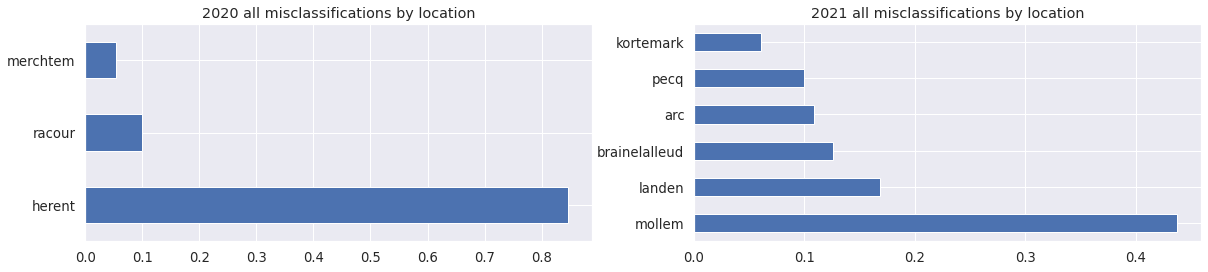

In [18]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1);df_merged.query('year==2020 & correct==False').location.value_counts(normalize=True).plot(kind='barh', title='2020 all misclassifications by location');
plt.subplot(1,2,2);df_merged.query('year==2021 & correct==False').location.value_counts(normalize=True).plot(kind='barh', title='2021 all misclassifications by location');

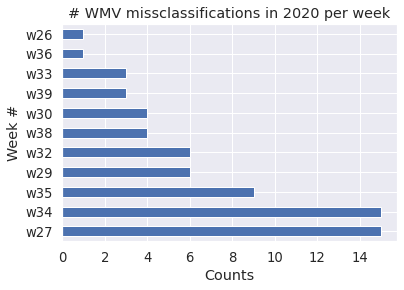

In [19]:
df_merged.query('year==2020 & actual_class==\'wmv\' & pred_class!=\'wmv\'')['date'].value_counts().plot(kind='barh');
plt.title("# WMV missclassifications in 2020 per week")
plt.ylabel('Week #');plt.xlabel('Counts');
plt.savefig(f"/home/kalfasyan/Dropbox/worklaptop_results/missclassifications_2020_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')

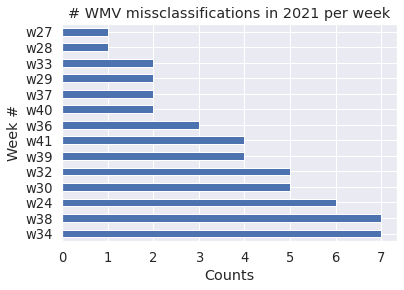

In [20]:
df_merged.query('year==2021 & actual_class==\'wmv\' & pred_class!=\'wmv\'')['date'].value_counts().plot(kind='barh');
plt.title("# WMV missclassifications in 2021 per week")
plt.ylabel('Week #');plt.xlabel('Counts');
plt.savefig(f"/home/kalfasyan/Dropbox/worklaptop_results/missclassifications_2021_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')

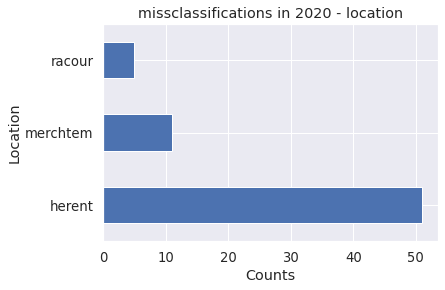

In [21]:
df_merged.query('year==2020 & actual_class==\'wmv\' & pred_class!=\'wmv\'')['location'].value_counts().plot(kind='barh');
plt.title("missclassifications in 2020 - location")
plt.ylabel('Location');plt.xlabel('Counts');
plt.savefig(f"/home/kalfasyan/Dropbox/worklaptop_results/missclassifications_2020_location_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')

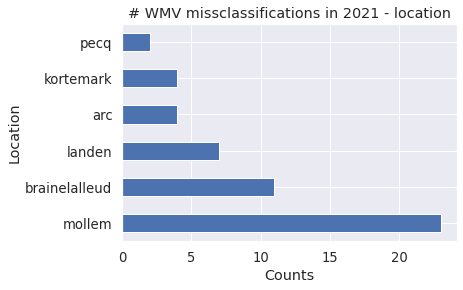

In [22]:
df_merged.query('year==2021 & actual_class==\'wmv\' & pred_class!=\'wmv\'')['location'].value_counts().plot(kind='barh');
plt.title("# WMV missclassifications in 2021 - location")
plt.ylabel('Location');plt.xlabel('Counts');
plt.savefig(f"/home/kalfasyan/Dropbox/worklaptop_results/missclassifications_2021_location_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')

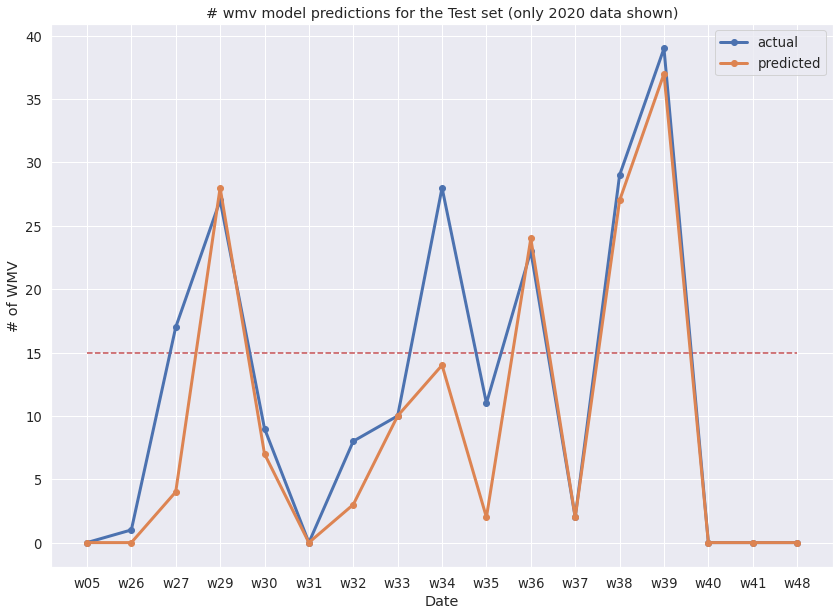

In [23]:
year = 2020
ac_wmv = []
pr_wmv = []
dates = []
for i, sub in df_merged[df_merged.year==year].groupby('date'):
    ac_wmv.append(sub[sub.actual_class=='wmv'].shape[0])
    pr_wmv.append(sub[sub.pred_class=='wmv'].shape[0])
    dates.append(i)

ax = pd.DataFrame({"actual": ac_wmv, "predicted":pr_wmv}).plot(figsize=(14,10), xticks=np.arange(0,len(dates)), linewidth=3,style='o-')
ax.set_xticklabels(dates);
ax.hlines(15, 0,len(dates)-1, linestyles='dashed', color='r')
ax.set_ylabel("# of WMV");
ax.set_xlabel("Date")
ax.set_title(f"# wmv model predictions for the Test set (only {year} data shown)")
plt.savefig(f"/home/kalfasyan/Dropbox/worklaptop_results/predplot_{year}_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')

Outlier plate: UNDISTORTED_merchtem_20200922_M3_4056x3040.png


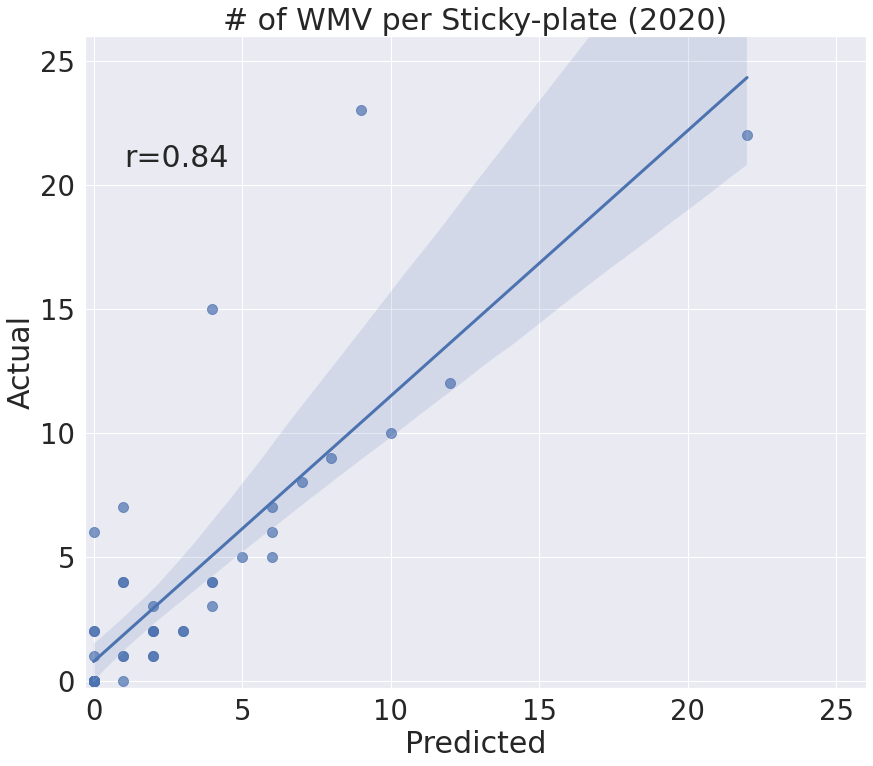

In [24]:
year = 2020

actuals, predictions, platenames = [],[],[]
for i, sub in df_merged.query(f'year=={year}').groupby('platename'):
    actuals.append(len(sub.query(f"actual_class==\'wmv\'")))
    predictions.append(len(sub.query(f"pred_class==\'wmv\'")))
    platenames.append(i)
outlier_idx = np.argmax(actuals)
del actuals[outlier_idx]
del predictions[outlier_idx]
print(f"Outlier plate: {platenames[outlier_idx]}")
del platenames[outlier_idx]

sub = pd.DataFrame({"Actual":actuals, "Predicted":predictions, "Platenames":platenames})


sns.set(font_scale=2.5)
plt.figure(figsize=(14,12));
g = sns.regplot(data=sub, x='Predicted',y='Actual', scatter=True, scatter_kws={"s": 100, "alpha":.7}, line_kws={'linewidth':3});
g.set_title(f'# of WMV per Sticky-plate ({year})')

from scipy import stats
r, p = stats.pearsonr(sub["Actual"], sub["Predicted"])
ax = plt.gca()
ax.text(.05, .8, f"r={r:.2f}", fontsize=30,
        transform=ax.transAxes)
if year==2021:
    ax.set(ylim=(-.3,60),xlim=(-.3,60))
elif year==2020:
    ax.set(ylim=(-.3,26),xlim=(-.3,26))

plt.savefig(f"/home/kalfasyan/Dropbox/worklaptop_results/regplot_{year}_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')
plt.show()

In [25]:
def plot_samples(df=pd.DataFrame(), noaxis=True, title='label'):
    seed=42
    df.reset_index(drop=True, inplace=True)
    #df = df.sample(14, replace=False, random_state=seed).reset_index(drop=True)

    plt.figure(figsize=(20,12))

    for i in tqdm(range(14)):
        plt.subplot(4,5,i+1)
        img = read_image(df.loc[i].filename)
        plt.imshow(img);
        if title == 'label':
            plt.title(df.loc[i].label)
        if noaxis:
            plt.axis('off')

if year==2021:
    overpredicted_pname = sub.loc[(sub['Actual'] - sub['Predicted']).abs().idxmax()].Platenames
    df_over = df_merged.query(f'platename==\'{overpredicted_pname}\' & pred_class==\'wmv\'')
    df_over.actual_class
    plot_samples(df_over)
    plt.savefig(f"/home/kalfasyan/Dropbox/worklaptop_results/overpredicted_{year}_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')

In [26]:
df_merged.query(f'platename==\'{weird_pname}\'').actual_class.value_counts()

NameError: name 'weird_pname' is not defined

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
df_merged.query('correct==False')['blur'].hist()
plt.xlim(0,300);plt.ylim(0,2000)
plt.subplot(1,2,2)
df_merged.query('correct==True')['blur'].hist()
plt.xlim(0,300);plt.ylim(0,2000);

In [ ]:
feature = "G"
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
df_merged.query('correct==False')[feature].hist();plt.title('Missclassifications');
# plt.xlim(0,300);plt.ylim(0,2000)
plt.subplot(1,2,2)
df_merged.query('correct==True')[feature].hist();plt.title('Correct');
# plt.xlim(0,300);plt.ylim(0,2000);

In [ ]:
df_merged.query('year==2020 & actual_class==\'wmv\' & pred_class!=\'wmv\' & location==\'herent\'')

In [ ]:
# dfs.plot_samples(df_merged.query('actual_class!=\'wmv\' & pred_class==\'wmv\''))

In [ ]:
# dfs.plot_samples(df_merged.query('nb_contours<=2 & actual_class==\'sw\'' ))

In [ ]:
dates

In [ ]:
def find_edge_cases(df, dist_threshold=5):
    edge_cases, edge_x, edge_y = [],[],[]
    for i,row in tqdm(df.iterrows()):
        plate_width = row.plate_width
        plate_height = row.plate_height

        x = row.yolo_x * plate_width
        y = row.yolo_y * plate_height

        edge_x.append(x)
        edge_y.append(y)
        
        if x > (plate_width-dist_threshold) or x < dist_threshold or y > (plate_height-dist_threshold) or y < dist_threshold:
            edge_cases.append(True)
        else:
            edge_cases.append(False)
    df['edge'] = edge_cases
    df['edge_x'] = edge_x
    df['edge_y'] = edge_y
    print(df[df['edge']==True].shape)
    return df

In [ ]:
tmp = find_edge_cases(df_merged.copy(), dist_threshold=250)

In [ ]:
# tmp.query(f"edge==True & actual_class==pred_class").shape[0] / tmp.query(f"edge==True").shape[0]

In [ ]:
# tmp.query(f"edge==False & actual_class==pred_class").shape[0] / tmp.query(f"edge==False").shape[0]

In [ ]:
list_edge, list_nonedge, bacc_edge, bacc_nonedge, dists = [],[],[],[],[]
for i in np.arange(200,1250,50):
    tmp = find_edge_cases(df_merged.copy(), dist_threshold=i)
    edge_cases = tmp[tmp.edge==True]
    nonedge_cases = tmp[tmp.edge==False]
    print(i)
    print(f"edge cases: {edge_cases.shape[0]}, accuraccy: {balanced_accuracy_score(y_true=edge_cases.actual_class, y_pred= edge_cases.pred_class)}")
    print(f"nonedge cases: {nonedge_cases.shape[0]}, accuraccy: {balanced_accuracy_score(y_true=nonedge_cases.actual_class, y_pred= nonedge_cases.pred_class)}")
    list_edge.append(edge_cases.shape[0])
    bacc_edge.append(balanced_accuracy_score(y_true=edge_cases.actual_class, y_pred= edge_cases.pred_class))
    list_nonedge.append(nonedge_cases.shape[0])
    bacc_nonedge.append(balanced_accuracy_score(y_true=nonedge_cases.actual_class, y_pred= nonedge_cases.pred_class))
    dists.append(i)

In [ ]:
df_edgecases = pd.DataFrame({"edge": list_edge, "nonedge": list_nonedge, "edge_bacc": bacc_edge, "nonedge_bacc": bacc_nonedge, "dists": dists})
# df_edgecases

In [ ]:
plt.figure(figsize=(14,8))
sns.lineplot(data=df_edgecases, x='dists', y='edge_bacc')
sns.lineplot(data=df_edgecases, x='dists', y='nonedge_bacc')
plt.legend(['based on edge insects', 'based on center insects'])
plt.xlabel('Distance from edges (pixels)')
plt.ylabel('Balanced accuracy score');
plt.savefig(f"/home/kalfasyan/Dropbox/worklaptop_results/edge_cases_accuracies.png", format='png', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(14,8))
sns.lineplot(data=df_edgecases, x='dists', y='edge')
sns.lineplot(data=df_edgecases, x='dists', y='nonedge')
plt.legend(['# of edge insects', '# of center insects'])
plt.xlabel('Distance from edges (pixels)')
plt.ylabel('# of insects');
plt.savefig(f"/home/kalfasyan/Dropbox/worklaptop_results/edge_cases_counts.png", format='png', bbox_inches='tight')

In [ ]:
tmp = find_edge_cases(df_merged.copy(), dist_threshold=400)

# tmp = tmp[tmp['edge']].reset_index(drop=True)
tmp['correct'] = tmp.actual_class == tmp.pred_class
np.corrcoef(tmp.correct.astype(int), tmp.edge.astype(int))